In [1]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import os
import math

from matplotlib.animation import FuncAnimation

pd.set_option('display.max_columns', None)

In [2]:
import matplotlib.font_manager as fm

font_path = "C:/Windows/Fonts/NanumSquareRoundR.TTF"
font_name = fm.FontProperties(fname = font_path).get_name()
plt.rc('font', family = font_name)
plt.rcParams['font.family']

['NanumSquareRound']

In [3]:
os.chdir('/Users/이진우/Desktop/학회/4기활동/심화스터디, 세션/Network_Analysis/플젝')

Node = pd.read_csv('./StopID_geo2_new.csv')
Edge = pd.read_csv('./StopIID_weighted_edge.csv')

In [4]:
# 그냥 모든 엣지를 1로 통일하자!
# 거리가 멀다해서 감염정도가 줄어드는건 아니니까!
Edge['weight'] = 1

In [5]:
sum(Edge.weight < 1)

0

# 필요없는 edge 솎아내기

In [6]:
Node_list = list(Node.id.unique())
source_list = list(Edge.source.unique())
target_list = list(Edge.target.unique())
source_list.extend(target_list)
edge_list = list(set(source_list))
BAD = []

for E in edge_list:
    if E not in Node_list:
        BAD.append(E)
        
len(BAD)

675

In [7]:
bad_idx1 = Edge[Edge.source.isin(BAD)].index
Edge = Edge.drop(bad_idx1)

bad_idx2 = Edge[Edge.target.isin(BAD)].index
Edge = Edge.drop(bad_idx2)

# 각 지역구에 정거장이 몇개?

- 우선 서울 GeoJson 파일을 dataframe으로 변환

In [8]:
# 서울 GeoJson 불러오기
import json

with open('seoul_geo.json', encoding='utf-8') as json_file:
    Geo = json.load(json_file, encoding='UTF8')

In [9]:
neighborhoods_data = Geo['features']

geo_data = pd.DataFrame(columns=['kr','eng','coordinates'])

for data in neighborhoods_data:
    kr = data['properties']['name']
    eng = data['properties']['name_eng']
    Coord = data['geometry']['coordinates'][0]
    
    coord_list = []
    for c in range(len(Coord)):
        coord_tuple = tuple(Coord[c])
        coord_list.append(coord_tuple)
        
    tmp = {'kr':kr, 'eng':eng, 'coordinates':coord_list}
    geo_data = geo_data.append(tmp, ignore_index=True)
    
geo_data.head()

kr          eng                                        coordinates
0  강동구  Gangdong-gu  [(127.11519584981606, 37.557533180704915), (12...
1  송파구    Songpa-gu  [(127.0690698130372, 37.522279423505026), (127...
2  강남구   Gangnam-gu  [(127.05867359288398, 37.52629974922568), (127...
3  서초구    Seocho-gu  [(127.01397119667513, 37.52503988289669), (127...
4  관악구    Gwanak-gu  [(126.98367668291802, 37.473856492692086), (12...

- 각 노드정류장을 해당 지역구에 매칭시키자
- 이때 각 지역구 Polygon 안에 있는지의 여부로 확인

In [11]:
from shapely.geometry import Point, Polygon

for i in geo_data.index:
    poly = Polygon(geo_data.at[i,'coordinates'])
    for j in Node.index:
        lng = Node.at[j,'longitude']
        lat = Node.at[j,'latitude']
        if Point(lng,lat).within(poly)==True:
            Node.at[j,'kr'] = geo_data.at[i,'kr']
            Node.at[j,'eng'] = geo_data.at[i,'eng']
            
Node.head(2)

label         id   longitude   latitude   total   kr        eng  \
0      종로2가사거리  100000001  126.987786  37.569764   31570  종로구  Jongno-gu   
1  창경궁.서울대학교병원  100000002  126.996520  37.579179  130164  종로구  Jongno-gu   

                                    region_color  
0  [0.21197668 1.         0.         1.        ]  
1  [0.21197668 1.         0.         1.        ]

In [12]:
# 서울안에 있지 않은 지역의 정류장도 'Not_Seoul' 카테고리로 정해놓자
Node.loc[Node.eng.isna(), 'kr'] = 'Not_Seoul'
Node.loc[Node.eng.isna(), 'eng'] = 'Not_Seoul'
Node.eng.isna().sum()

0

- 지역구에 따른 색깔도 배정해주자

In [13]:
kr = list(Node.kr.values)
unique_kr = list(set(Node.kr.values))

cmap = plt.get_cmap('gist_rainbow')
colors = cmap(np.linspace(0,1,len(set(kr))))

dic = {}
for i in range(len(colors)):
    dic[unique_kr[i]] = colors[i]
    
print(dic['강남구'])
Node['region_color'] = Node['kr'].map(dic)

[0.         0.92391304 1.         1.        ]


# 지역별 노드들을 dataframe형태로 저장합시당

In [14]:
N_I_R = Node.groupby('kr')['id'].unique().reset_index()

for idx in N_I_R.index:
    N_I_R.at[idx,'id'] = N_I_R.at[idx,'id'].tolist()

# 그래프 인스턴스 생성
- 중복도 허용해야하므로 첨에는 multigraph()
- 그담엔 DiGraph()로 합쳐버리기

In [15]:
MG = nx.MultiGraph()

for i in Node.index:
    MG.add_node(Node.at[i,'id'],
                     label=Node.at[i,'label'],
                     longitude=Node.at[i,'longitude'],
                     latitude=Node.at[i,'latitude'],
                     kr=Node.at[i,'kr'],
                     eng=Node.at[i,'eng'],
                     color=Node.at[i,'region_color'])
    
for i in Edge.index:
    MG.add_edge(Edge.at[i,'source'], 
               Edge.at[i,'target'], 
               weight=Edge.at[i,'weight'],
               distance=Edge.at[i,'distance'])

In [16]:
G = nx.DiGraph()
G.add_nodes_from(MG.nodes(data=True))
for u, v, k, d in MG.edges(keys=True, data=True):
    if G.has_edge(u, v) == True: # weight만 가중해주고 distance는 한번만으로 충분하니까~
        G[u][v]['weight']+=d['weight']
    else:
        G.add_edge(u, v, weight=d['weight'])
        G.add_edge(u, v, distance=d['distance'])

In [17]:
for u,v,w in G.edges(data=True):
    G[u][v]['weight2'] = 1/G[u][v]['weight']
G.edges(data=True)

OutEdgeDataView([(100000001, 101000002, {'weight': 3, 'distance': 0.6020042571247468, 'weight2': 0.3333333333333333}), (100000001, 100000389, {'weight': 3, 'distance': 0.14619050048143406, 'weight2': 0.3333333333333333}), (100000002, 100000003, {'weight': 18, 'distance': 0.42236904015665866, 'weight2': 0.05555555555555555}), (100000002, 100000102, {'weight': 7, 'distance': 0.5216585552174853, 'weight2': 0.14285714285714285}), (100000002, 100000122, {'weight': 4, 'distance': 0.5054695973327096, 'weight2': 0.25}), (100000002, 100000076, {'weight': 6, 'distance': 0.7247655927678297, 'weight2': 0.16666666666666666}), (100000003, 100000005, {'weight': 16, 'distance': 0.4932349167907696, 'weight2': 0.0625}), (100000003, 100000130, {'weight': 1, 'distance': 0.4031968991401549, 'weight2': 1.0}), (100000003, 107000009, {'weight': 1, 'distance': 1.2499295535568455, 'weight2': 1.0}), (100000004, 100000388, {'weight': 4, 'distance': 0.2408995871140542, 'weight2': 0.25}), (100000004, 101000001, {'w

In [18]:
L = {}
for i in Node.index:
    ID = Node.at[i,'id']
    long = Node.at[i,'longitude']
    lat = Node.at[i,'latitude']
    L[ID] = np.array([long,lat])

In [19]:
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
weights2 = [G[u][v]['weight2'] for u,v in edges]

In [20]:
ids = G.nodes()
nodes = G.nodes(data=True)
region_color = [nodes[u]['color'] for u in ids]

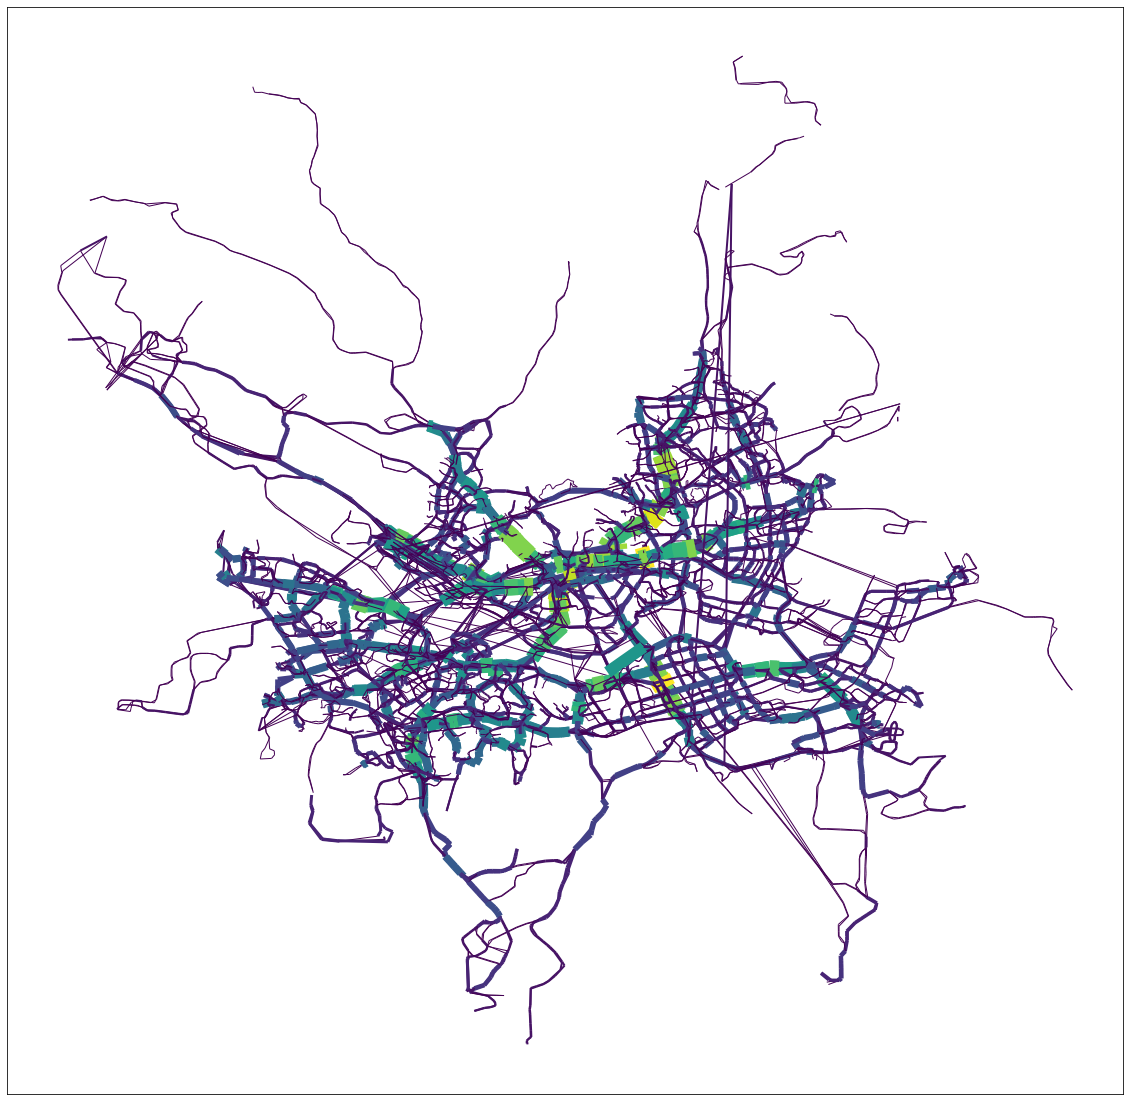

In [21]:
plt.figure(figsize=(20,20))
nx.draw_networkx(G,L,node_size=0,
                 width=weights, 
                 edge_color=weights,
                 with_labels=False, arrows=False, 
                 node_color=region_color)

# Pagerank

In [104]:
pr = nx.pagerank(G,weight='weight',alpha=0.95)

In [105]:
pr2 = pd.DataFrame(columns=['node','pr'])
for n,d in pr.items():
    tmp = {'node':n, 'pr':d}
    pr2 = pr2.append(tmp, ignore_index=True)
    
pr2.sort_values(by='pr', ascending=False, inplace=True)
pr2.reset_index(drop=True, inplace=True)

In [106]:
pr100 = pr2[0:100].node.tolist()

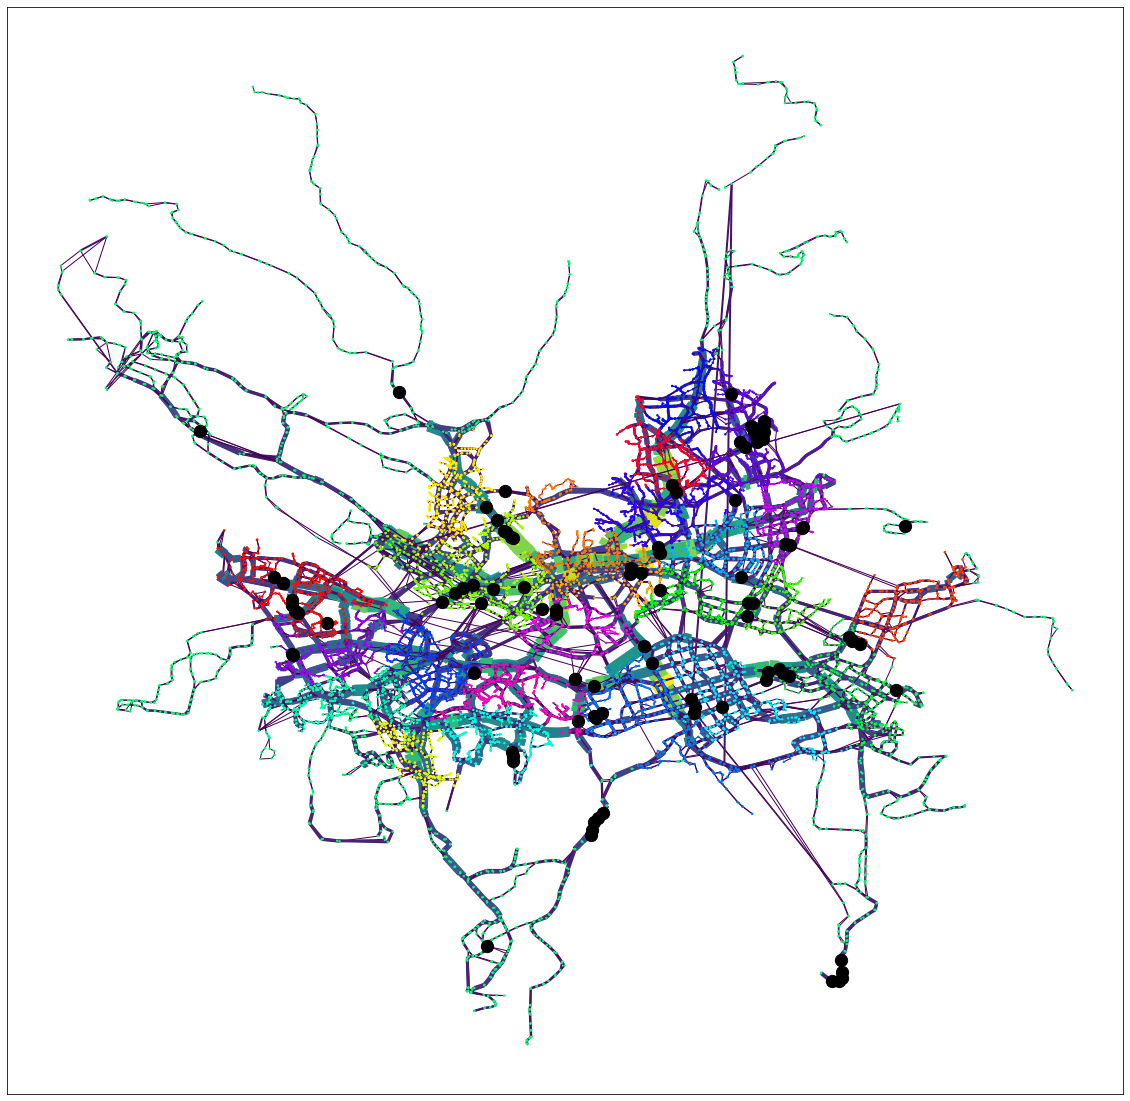

In [107]:
plt.figure(figsize=(20,20))
#nx.draw_networkx(G,L,node_size=2,width=weights, edge_color=weights,with_labels=False, arrows=False)
nx.draw_networkx_nodes(G,L,node_color=region_color,node_size=2)
nx.draw_networkx_nodes(G,L,node_color='k',nodelist=pr100,node_size=150)
nx.draw_networkx_edges(G,L,width=weights, edge_color=weights,withlabels=False,arrows=False)

# btw100

In [22]:
btw = nx.betweenness_centrality(G,weight='weight2')

In [23]:
btw2 = pd.DataFrame(columns=['node','btw'])
for n,d in btw.items():
    tmp = {'node':n, 'btw':d}
    btw2 = btw2.append(tmp, ignore_index=True)
    
btw2

node           btw
0      100000001.0  0.000000e+00
1      100000002.0  0.000000e+00
2      100000003.0  2.917566e-07
3      100000004.0  0.000000e+00
4      100000005.0  5.454579e-07
...            ...           ...
12553  277101746.0  0.000000e+00
12554  277102712.0  0.000000e+00
12555  277103813.0  1.268507e-08
12556  277103814.0  0.000000e+00
12557  277103898.0  0.000000e+00

[12558 rows x 2 columns]

In [24]:
btw2.sort_values(by='btw', ascending=False, inplace=True)

In [25]:
btw2.reset_index(drop=True, inplace=True)

In [133]:
btw_2_100 = btw2[0:400].node.tolist()

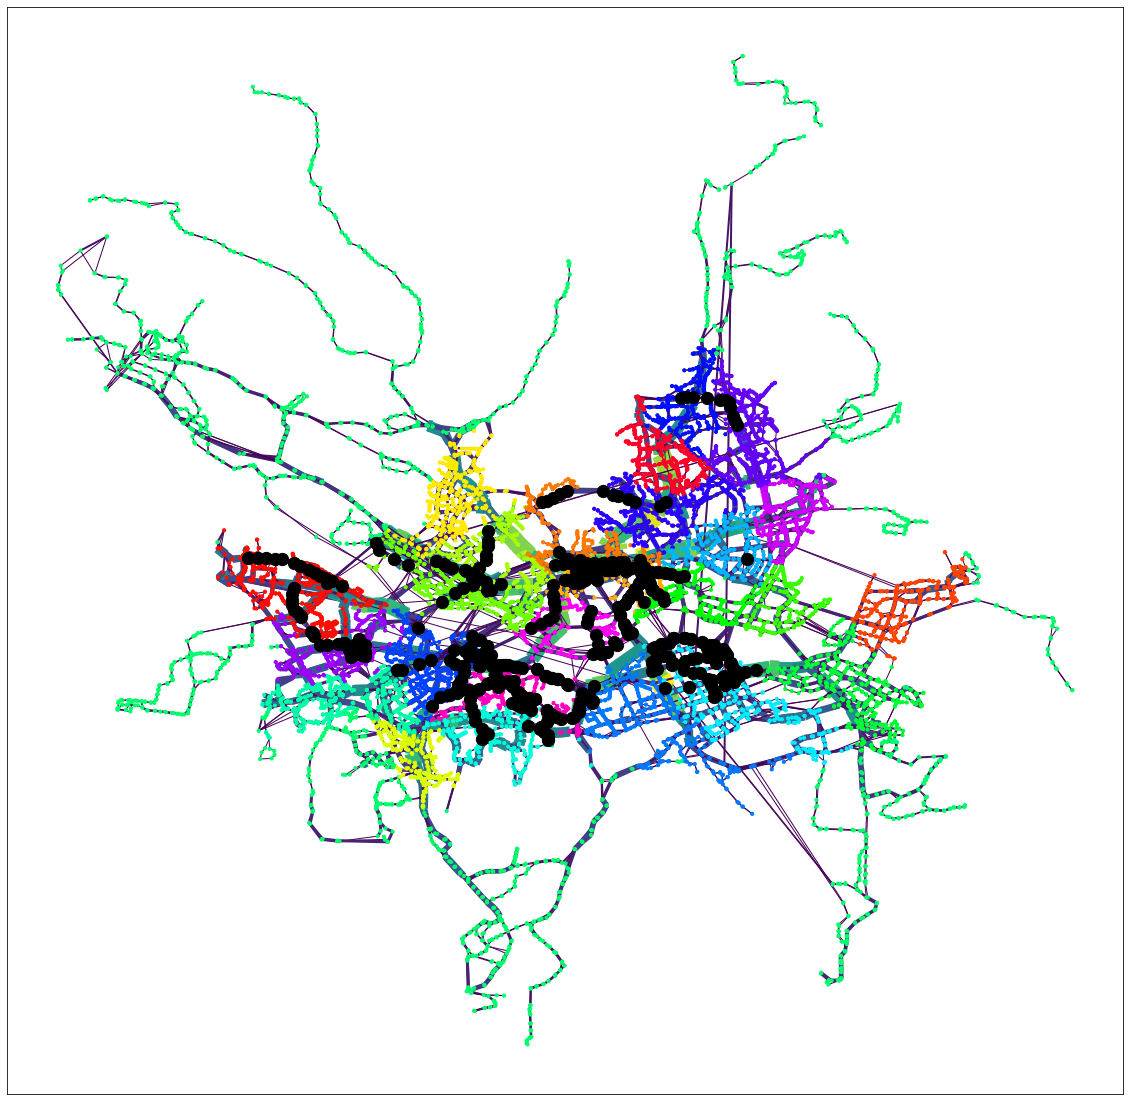

In [134]:
plt.figure(figsize=(20,20))
#nx.draw_networkx(G,L,node_size=2,width=weights, edge_color=weights,with_labels=False, arrows=False)
nx.draw_networkx_nodes(G,L,node_color=region_color,node_size=10)
nx.draw_networkx_nodes(G,L,node_color='k',nodelist=btw_2_100,node_size=150)
nx.draw_networkx_edges(G,L,width=weights, edge_color=weights,withlabels=False,arrows=False)

# closeness centrality
- 주의 : 중요할수록 가중치가 작아야함
- 즉, weight대신 distance 고대로 써주면 됨.

In [28]:
cls = nx.closeness_centrality(G,distance='weight2')

In [29]:
cls2 = pd.DataFrame(columns=['node','cls'])
for n,d in cls.items():
    tmp = {'node':n, 'cls':d}
    cls2 = cls2.append(tmp, ignore_index=True)

cls2.sort_values(by='cls', ascending=False, inplace=True)
cls2.reset_index(drop=True, inplace=True)

In [30]:
cls100 = cls2[0:100].node.tolist()

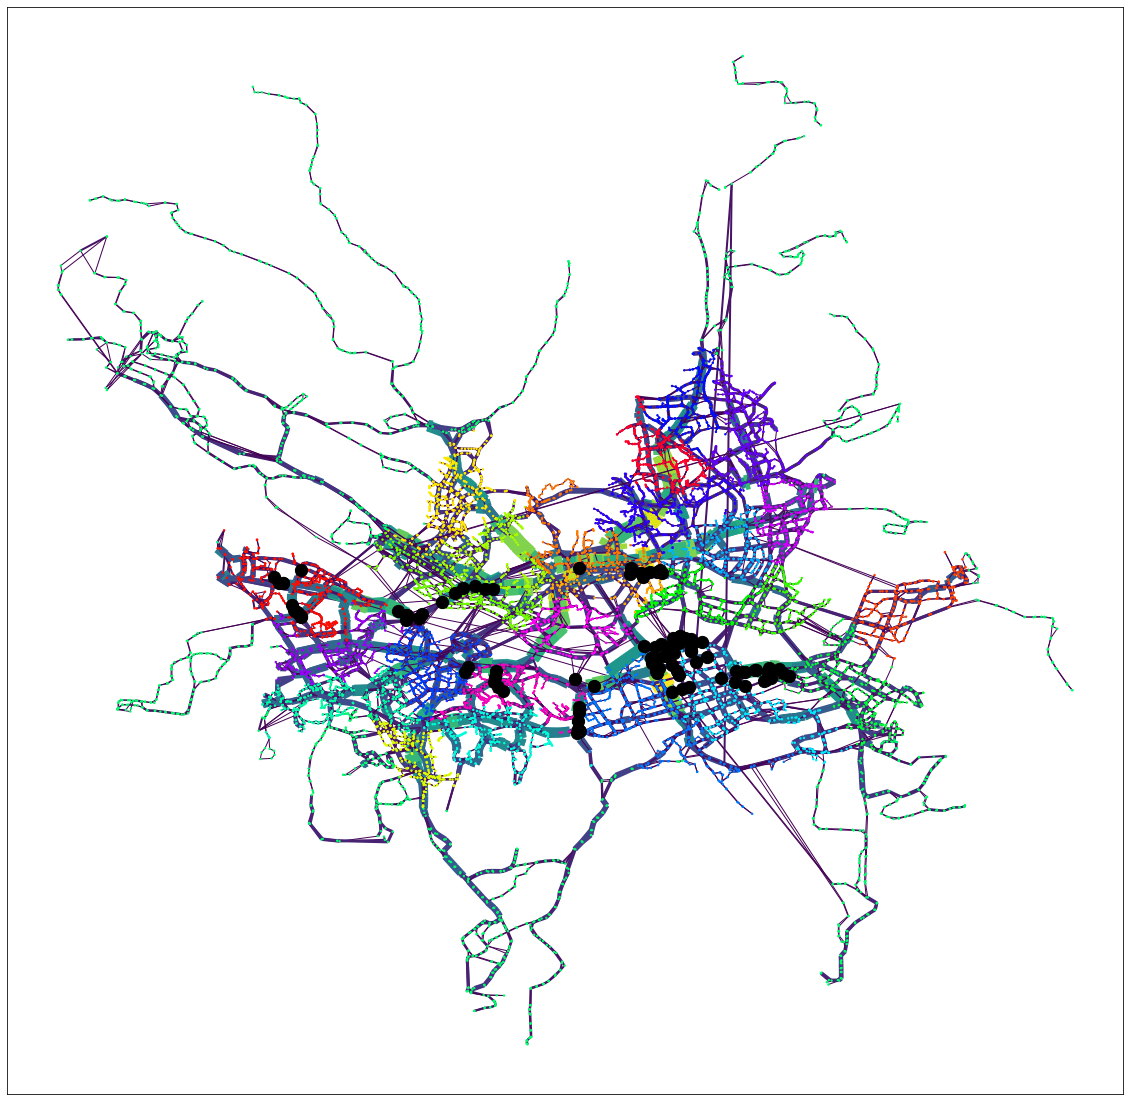

In [72]:
plt.figure(figsize=(20,20))
#nx.draw_networkx(G,L,node_size=2,width=weights, edge_color=weights,with_labels=False, arrows=False)
nx.draw_networkx_nodes(G,L,node_color=region_color,node_size=2)
nx.draw_networkx_nodes(G,L,node_color='k',nodelist=cls100,node_size=150)
nx.draw_networkx_edges(G,L,width=weights, edge_color=weights,withlabels=False,arrows=False)

# Weighted degree top100

In [126]:
deg100 = sorted(G.degree(weight='weight'), key=lambda x: x[1], reverse=True)[0:100]
top100 = []

for i in range(len(deg100)):
    top100.append(deg100[i][0])

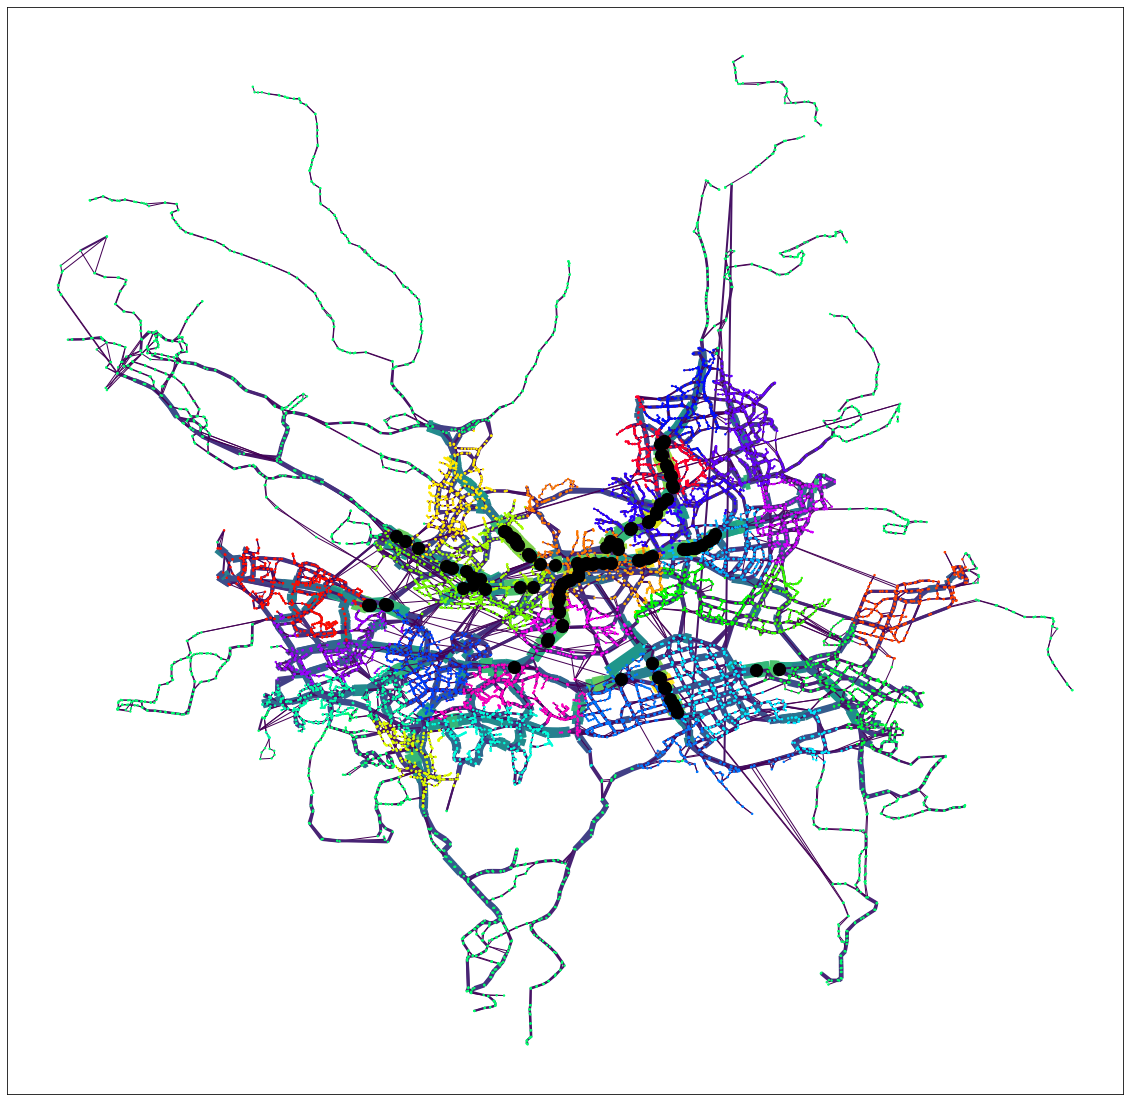

In [127]:
plt.figure(figsize=(20,20))
#nx.draw_networkx(G,L,node_size=2,width=weights, edge_color=weights,with_labels=False, arrows=False)
nx.draw_networkx_nodes(G,L,node_color=region_color,node_size=2)
nx.draw_networkx_nodes(G,L,node_color='k',nodelist=top100,node_size=150)
nx.draw_networkx_edges(G,L,width=weights, edge_color=weights,withlabels=False,arrows=False)

# degree plot (unweighted vs weighted)
- 별 차이 없음

In [34]:
import collections

def draw_degree_dist(g,i,w):
    dg_sq = []
    if w=='w':
        dg_sq = sorted([d for n,d in g.degree(weight='weight')], reverse=True)
        print(np.mean(dg_sq))
        s = 'Weighted_degree_hist'
    elif w=='n': 
        dg_sq = sorted([d for n,d in g.degree()], reverse=True)
        print(np.mean(dg_sq))
        s = 'Degree_hist'
    dg_cnt = collections.Counter(dg_sq)
    deg, cnt = zip(*dg_cnt.items())
    
    plt.subplot(2,1,i)
    plt.bar(deg, cnt)
    plt.title(s)

2.5750915750915753
5.78786430960344


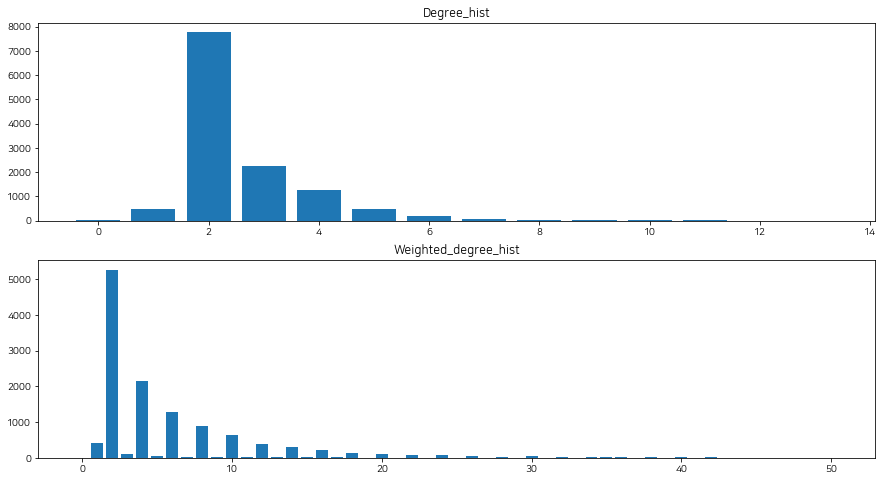

In [35]:
plt.figure(figsize=(15,8))
draw_degree_dist(G,1,'n')
draw_degree_dist(G,2,'w')

5.555502468545947


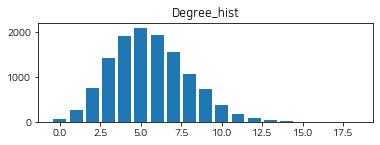

In [36]:
N = 12558
ER = nx.erdos_renyi_graph(n=N, p=0.00022, seed=None, directed=True)

draw_degree_dist(ER,1,'n')

5.611880872750438


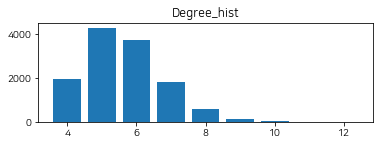

In [37]:
WS = nx.newman_watts_strogatz_graph(n=N, k=5, p=0.4)

draw_degree_dist(WS,1,'n')

5.998566650740564


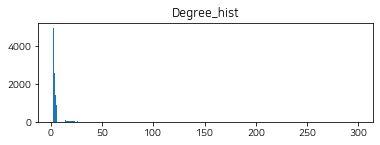

In [38]:
BA = nx.barabasi_albert_graph(n=N,m=3)

draw_degree_dist(BA,1,'n')

In [39]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 12558\nNumber of edges: 16169\nAverage in degree:   1.2875\nAverage out degree:   1.2875'

# 버스장 네트워크 조사

- 지역구당 정류장 갯수?

In [40]:
Number = Node.groupby('kr')['id'].count().reset_index().sort_values(by='id')[::-1].reset_index(drop=True).loc[1:,:]

state_geo = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'

import folium

m = folium.Map([37.557335000000002, 126.997985], zoom_start=10)

m.choropleth(
    geo_data = state_geo,
    data = Number,
    columns=['kr','id'],
    key_on='properties.name',
    fill_color='Reds',
    legend_name='id'
)

m

C:\Anaconda3\lib\site-packages\folium\folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


- 지역구당 weighted_degree_sum

In [41]:
A = Edge.groupby('source')['weight'].sum().reset_index()
B = Edge.groupby('target')['weight'].sum().reset_index()
A.rename(columns={'weight':'out'}, inplace=True)
B.rename(columns={'weight':'in'}, inplace=True)
C = pd.merge(Node, A, how='left', left_on='id', right_on='source')
D = pd.merge(C, B, how='left', left_on='id', right_on='target')
D = D.fillna(0)
D['total'] = D['out'] + D['in']
D_sorted = D.loc[np.argsort(-D.total)].reset_index(drop=True)

In [42]:
Weighted_degree = D_sorted.groupby('kr')['total'].sum().reset_index().sort_values(by='total')[::-1].reset_index(drop=True).loc[1:]

m = folium.Map([37.557335000000002, 126.997985], zoom_start=10)

m.choropleth(
    geo_data = state_geo,
    data = Weighted_degree,
    columns=['kr','total'],
    key_on='properties.name',
    fill_color='Reds',
    legend_name='total'
)

m

# Simulation 비교
1. top_degree vs top_btw vs random
2.  딱 하나의 지역구에서 랜덤 100개 정거장을 뽑아 전파

In [95]:
import EoN

# example
tmax=100                  # 시뮬레이션하는 최대 시간
iterations=100           # 시뮬레이션 반복수
tau=0.9                  # 어떤 시점 t에서 감염된 노드랑 연결된 한개의 이웃노드에게 전염시킬 확률
gamma=0.1                # 감염되어있는 노드가 시점 t에서 회복할 확률
rho=0.008                # 맨 처음에 이미 전염되어있는 노드비율

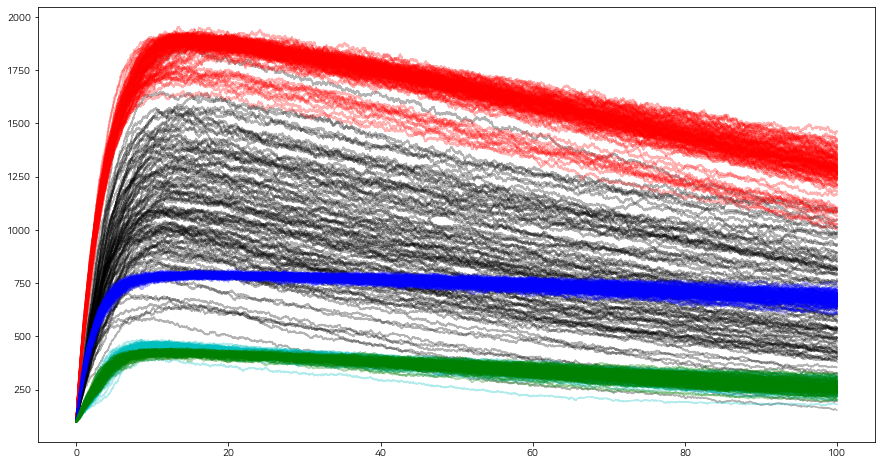

In [108]:
plt.figure(figsize=(15,8))

# 전체의 rho비율만큼 랜덤으로 노드들 뽑아 전염시켜놓고 시뮬레이션 (iterations만큼 반복)
for counter in range(iterations):
    t, S, I = EoN.fast_SIS(G, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight')
    # transmission_weight : 엣지 가중치만큼 전염율이 더 세짐.
    plt.plot(t, I, color='k', alpha=0.3)

# 만약 랜덤으로 뽑지 않고 특정 노드들만 선정하여 미리 전염시키고 시뮬레이션한다면
# rho 절대 쓰면 안되고 initial_infecteds 써야함!
# 이때 집어넣을 노드들 자료형은 List이고 각 노드들은 'id'이어야함!
# 물론 이전에 생성한 그래프 인스턴스 G에 들어있는 노드 id로.
for counter in range(iterations):
    # top weighted-degree 100 nodes
    t,S,I = EoN.fast_SIS(G, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=top100)
    plt.plot(t, I, color='r', alpha=0.3)

for counter in range(iterations):
    # top between centrality 100 nodes
    t,S,I = EoN.fast_SIS(G, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=btw_2_100)
    plt.plot(t, I, color='b', alpha=0.3)
    
for counter in range(iterations):
    # top pagerank 100 nodes
    t,S,I = EoN.fast_SIS(G, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=pr100)
    plt.plot(t, I, color='c', alpha=0.3)
    
for counter in range(iterations):
    # top closeness centrality 100 nodes
    t,S,I = EoN.fast_SIS(G, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=cls100)
    plt.plot(t, I, color='g', alpha=0.3)

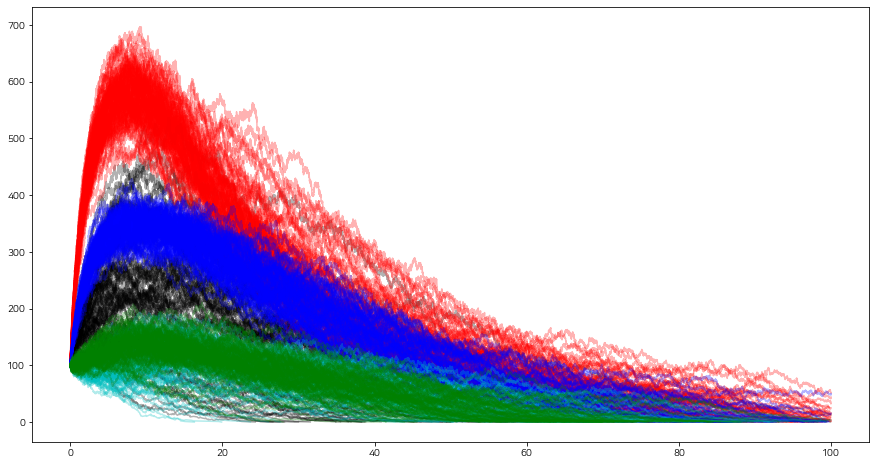

In [116]:
tau=0.5
gamma=0.5

plt.figure(figsize=(15,8))

for counter in range(iterations):
    t, S, I = EoN.fast_SIS(G, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight')
    plt.plot(t, I, color='k', alpha=0.3)
    
for counter in range(iterations):
    # top weighted-degree 100 nodes
    t,S,I = EoN.fast_SIS(G, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=top100)
    plt.plot(t, I, color='r', alpha=0.3)

for counter in range(iterations):
    # top between centrality 100 nodes
    t,S,I = EoN.fast_SIS(G, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=btw_2_100)
    plt.plot(t, I, color='b', alpha=0.3)
    
for counter in range(iterations):
    # top pagerank 100 nodes
    t,S,I = EoN.fast_SIS(G, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=pr100)
    plt.plot(t, I, color='c', alpha=0.3)
    
for counter in range(iterations):
    # top closeness centrality 100 nodes
    t,S,I = EoN.fast_SIS(G, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=cls100)
    plt.plot(t, I, color='g', alpha=0.3)

# 특정 지역 하나만 선택해서 simulation하자
- 그 지역 내 100개의 정거장을 랜덤샘플링
- 그리고 'Infected' plot을 확인

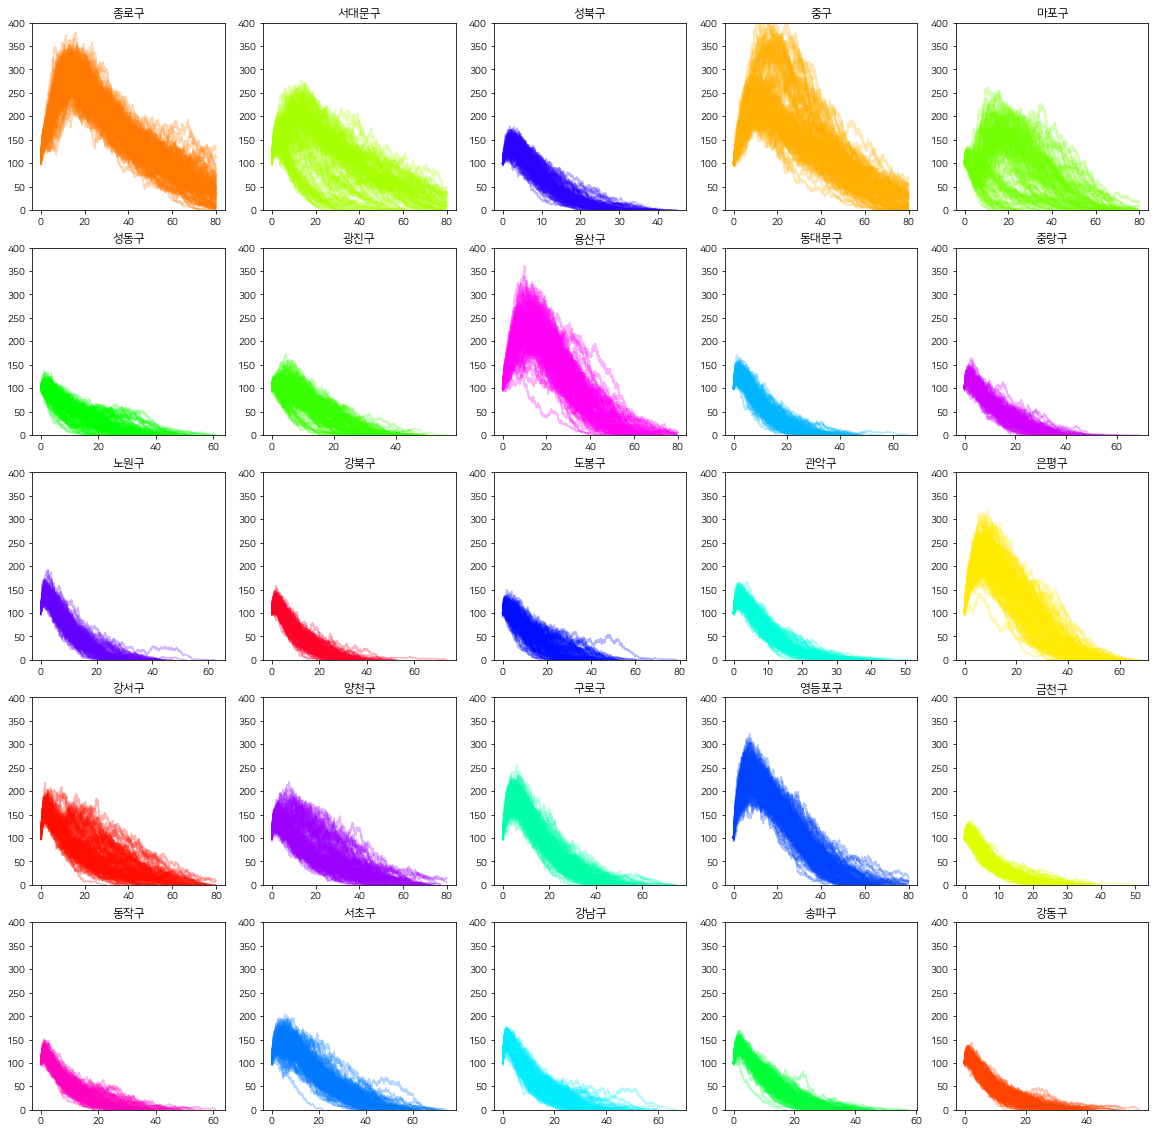

In [45]:
지역구 = list(Node.kr.unique())
지역구.remove('Not_Seoul')
i = 1
Mean_infected = pd.DataFrame(columns=['kr','mean'])
plt.figure(figsize=(20,20))

for region in 지역구:
    region_samples = list(Node[Node['kr']==region].sample(n=100).id)
    color = dic[region]
    Sum = 0
    
    plt.subplot(5,5,i)
    for counter in range(100):
        t,S,I = EoN.fast_SIS(G, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=region_samples)
        Sum = Sum + np.sum(I)
        
        plt.plot(t,I,color=color,alpha=0.3,label=region)
        plt.title(region)
        plt.ylim(0,400)
    
    mean = Sum/100
    tmp = {'kr':region, 'mean':mean}
    Mean_infected = Mean_infected.append(tmp, ignore_index=True)
    i += 1

- 각 지역구가 퍼뜨린 량?

In [46]:
m = folium.Map([37.557335000000002, 126.997985], zoom_start=10)

m.choropleth(
    geo_data = state_geo,
    data = Mean_infected,
    columns=['kr','mean'],
    key_on='properties.name',
    fill_color='Reds',
    legend_name='mean'
)

m

C:\Anaconda3\lib\site-packages\folium\folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


- 결과적으로 어디 지역으로 많이 퍼졌나?

In [47]:
import folium

In [48]:
def display_folium(Map=m, data=N_I_R):
    m.choropleth(
        geo_data = state_geo,
        data = N_I_R,
        columns=['kr','infected_results'],
        key_on='properties.name',
        fill_color='Reds',
        legend_name='infected_results'
    )
    return m

In [49]:
def Simulation(Map=m, nodelist=None, rho=None, iteration=1):
    sim_kwargs = {'pos': L}
    N_I_R['infected_results']=0
    
    for j in range(iteration):
        sim = EoN.fast_SIS(G, tau, gamma, rho=rho, tmax=tmax, 
                           initial_infecteds=nodelist,
                           transmission_weight='weight', 
                           return_full_data=True, 
                           sim_kwargs = sim_kwargs)

        for idx in N_I_R.index:
            stations_list = N_I_R.at[idx,'id']
            Sum = 0
            for i in range(50):
                tmp_dict = sim.get_statuses(nodelist=stations_list,time=i)
                tmp_val = sum(state=='I' for state in tmp_dict.values())
                Sum += tmp_val
            N_I_R.at[idx,'infected_results']+=Sum
    
    N_I_R['infected_results'] /= iteration
    
    return display_folium(Map=m, data=N_I_R)

In [50]:
m = folium.Map([37.557335000000002, 126.997985], zoom_start=10)
Simulation(Map=m, rho=rho, iteration=100)
m

In [51]:
tau = 0.9
gamma = 0.1
region = '마포구'
region_samples = list(Node[Node['kr']==region].sample(n=100).id)

m = folium.Map([37.557335000000002, 126.997985], zoom_start=10)
Simulation(Map=m, nodelist = region_samples, iteration=30)
m

In [109]:
def _display_time_series_(self, fig, t, ts_plots, ts_list, timelabel):
        if ts_list is None:
            ts_list = self._time_series_list_
        elif self._simulation_time_series_ not in ts_list:
            ts_list.append(self._simulation_time_series_)
        
        ts_axes = []
        time_markers = []
        ts_plot_count = len(ts_plots)        
        for cnt, ts_plot in enumerate(ts_plots[:-1]):
            ax = fig.add_subplot(ts_plot_count, 2, 2*(cnt+1))
            ax.set_xticks([])
            
            for ts in reversed(ts_list):
                ts._plot_(ax, ts_plot)  
                              
            ax.legend()
            
            if self._tex_:
                ax.set_title(", ".join(['${}$'.format(status) for status in ts_plot]))
            else:
                ax.set_title(", ".join(ts_plot))
                
            tm = ax.axvline(x=t, linestyle='--', color='k')
            ts_axes.append(ax)
            time_markers.append(tm)
            
        ax = fig.add_subplot(ts_plot_count, 2, 2*ts_plot_count)
        ax.set_xlabel(timelabel)
        ts_plot = ts_plots[-1]
        
        for ts in reversed(ts_list):
            ts._plot_(ax, ts_plot)                
        ax.legend()
        
        if self._tex_:
            ax.set_title(", ".join(['${}$'.format(status) for status in ts_plot]))
        else:
            ax.set_title(", ".join(ts_plot))

        tm = ax.axvline(x=t, linestyle='--', color='k')
        ts_axes.append(ax)
        time_markers.append(tm)
        return ts_axes, time_markers

In [111]:
from matplotlib.animation import FuncAnimation
import random

def animate(self, frame_times=None, ts_plots = None, 
                ts_list = None, nodelist=None, status_order=False, timelabel=r'$t$',  
                pos = None, statuses_to_plot = None, **nx_kwargs):
        if frame_times is None:
            frame_times = np.linspace(0,self._t_[-1], 101)
        if statuses_to_plot is None:
            statuses_to_plot = self._possible_statuses_
        if ts_plots is None:
            ts_plots = statuses_to_plot
        if ts_plots:
            fig = plt.figure(figsize=(20,12))
            graph_ax = fig.add_subplot(121)
        else:
            fig = plt.figure()
            graph_ax = fig.add_subplot(111)

        
        initial_status = self.get_statuses(self.G, frame_times[0])
    
        if pos is None:
            if self.pos is None:
                pos = nx.spring_layout(self.G)
            else:
                pos = self.pos
    
        if nodelist is None:
            nodelist = list(self.G.nodes())
            random.shuffle(nodelist)
            
        if status_order is False:
            status_order = []
            
        #First we draw all of the nodes with their original status, and without
        #putting particular status on top.  All nodes are in place, and their color
        #can be updated at a later time.
        #
        #Then we select the nodes whose status puts them on top initially
        #
        #For each status that goes on top, we draw it in a way that we'll be
        #able to redraw that status at a later time.
        drawn_nodes = self._display_graph_(pos, initial_status, nodelist, False, statuses_to_plot, graph_ax, **nx_kwargs)
        elevated = {status: [node for node in self.G if initial_status[node] == status] for status in status_order}

        drawn_elevated = {}
        for status in reversed(status_order):
            drawn_elevated[status]=[self._draw_specific_status_(pos, elevated[status], status, graph_ax, **nx_kwargs)] #making each a list so that I can change the entry in the list while still passing the same object
        #WARNING I'm defining a dict and while that definition is happening
        #it's drawing things
        
        
        
        
        if ts_plots:
            ts_axes, time_markers = _display_time_series_(self, fig, frame_times[0], ts_plots, ts_list, timelabel)
        else:
            ts_axes, time_markers = [], []
        plt.tight_layout()
        
        fargs = (pos, nodelist, drawn_nodes, drawn_elevated, status_order, graph_ax, ts_axes, time_markers, nx_kwargs)

        ani = FuncAnimation(fig, self._update_ani_, frames = frame_times, fargs = fargs, repeat=False)

        return ani

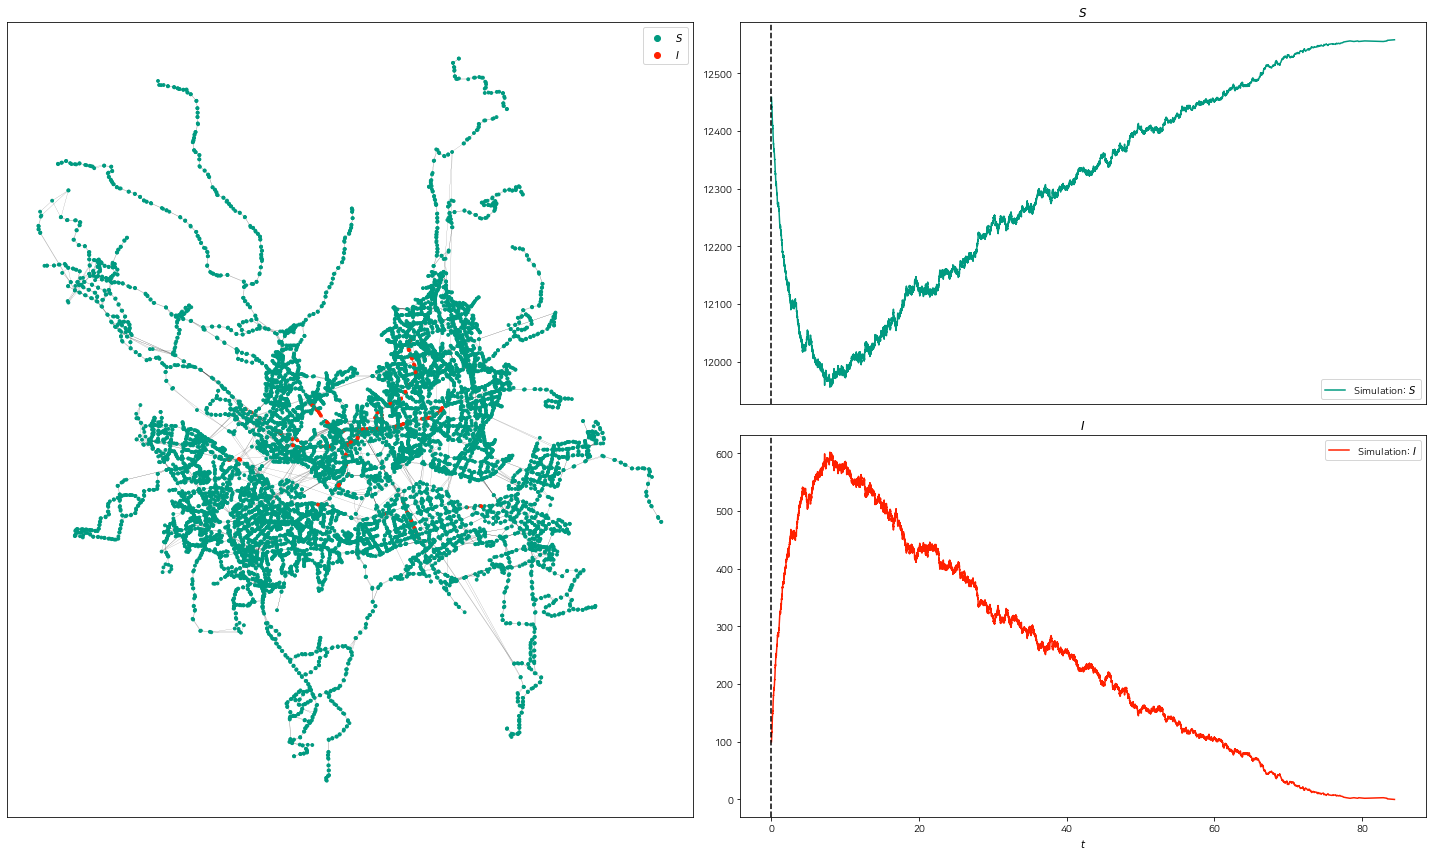

In [117]:
sim_kwargs = {'pos': L}

sim = EoN.fast_SIS(G, tau, gamma, initial_infecteds=top100, tmax=100, transmission_weight='weight', 
                   return_full_data=True, sim_kwargs = sim_kwargs)

# ts_plot : 애니메이션에 함꼐 넣을 plot ( I : 전염plot, S : recover plot)
ani = animate(self=sim,node_size = 8, ts_plot=['I'], width = 0.1,withlabels=False,arrows=False)

from matplotlib import animation, rc
from IPython.display import HTML

HTML(ani.to_html5_video())

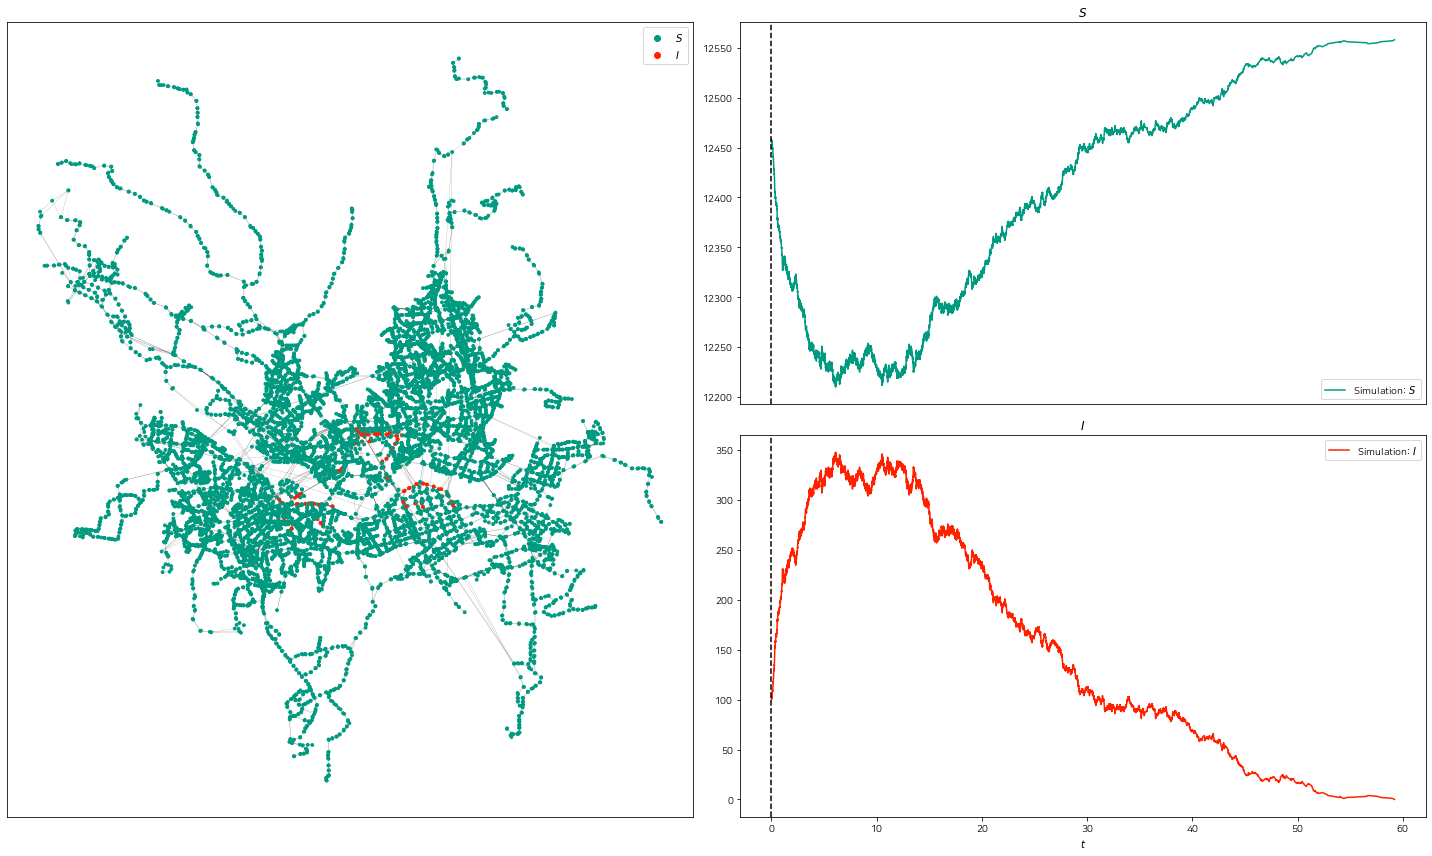

In [118]:
sim = EoN.fast_SIS(G, tau, gamma, initial_infecteds=btw_2_100, tmax=100, transmission_weight='weight', 
                   return_full_data=True, sim_kwargs = sim_kwargs)

ani = animate(self=sim,node_size = 8, ts_plot=['I'], width = 0.1,withlabels=False,arrows=False)

HTML(ani.to_html5_video())

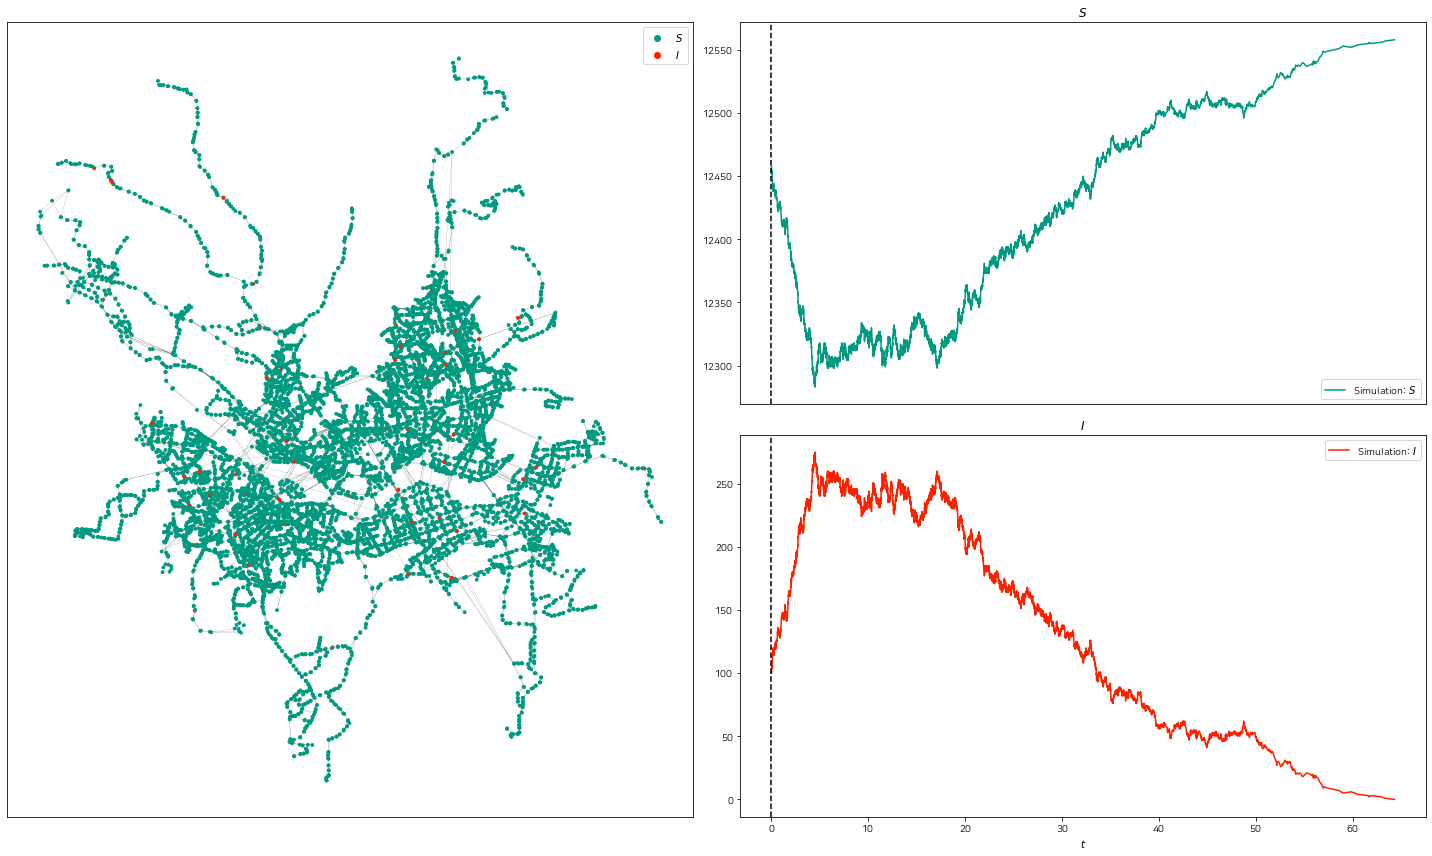

In [119]:
sim = EoN.fast_SIS(G, tau, gamma, rho=rho, tmax=100, transmission_weight='weight', 
                   return_full_data=True, sim_kwargs = sim_kwargs)

ani = animate(self=sim,node_size = 8, ts_plot=['I'], width = 0.1,withlabels=False,arrows=False)

HTML(ani.to_html5_video())